In [669]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss, recall_score, confusion_matrix, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [670]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Preprocessing

In [ ]:
# Replace BMI Null values by their mean
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(mean_bmi, inplace = True)
df['bmi'] = df['bmi'].round(2)

#Categorize features gender, residence_type, work_type
df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1})
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':3,'Never_worked':4})
df['smoking_status'] =  df['smoking_status'].replace({'never smoked':0, 'formerly smoked':1, 'smokes':2, 'Unknown': 0 })

In [672]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,48922,0,55.0,1,1,Yes,0,0,64.92,32.1,2,0
1,22590,0,5.0,0,0,No,3,1,83.75,18.1,0,0
2,53882,0,74.0,1,1,Yes,0,0,70.09,27.4,0,1
3,46436,0,13.0,0,0,No,3,1,122.31,15.3,0,0
4,15791,0,77.0,0,0,Yes,0,1,193.83,26.5,0,0


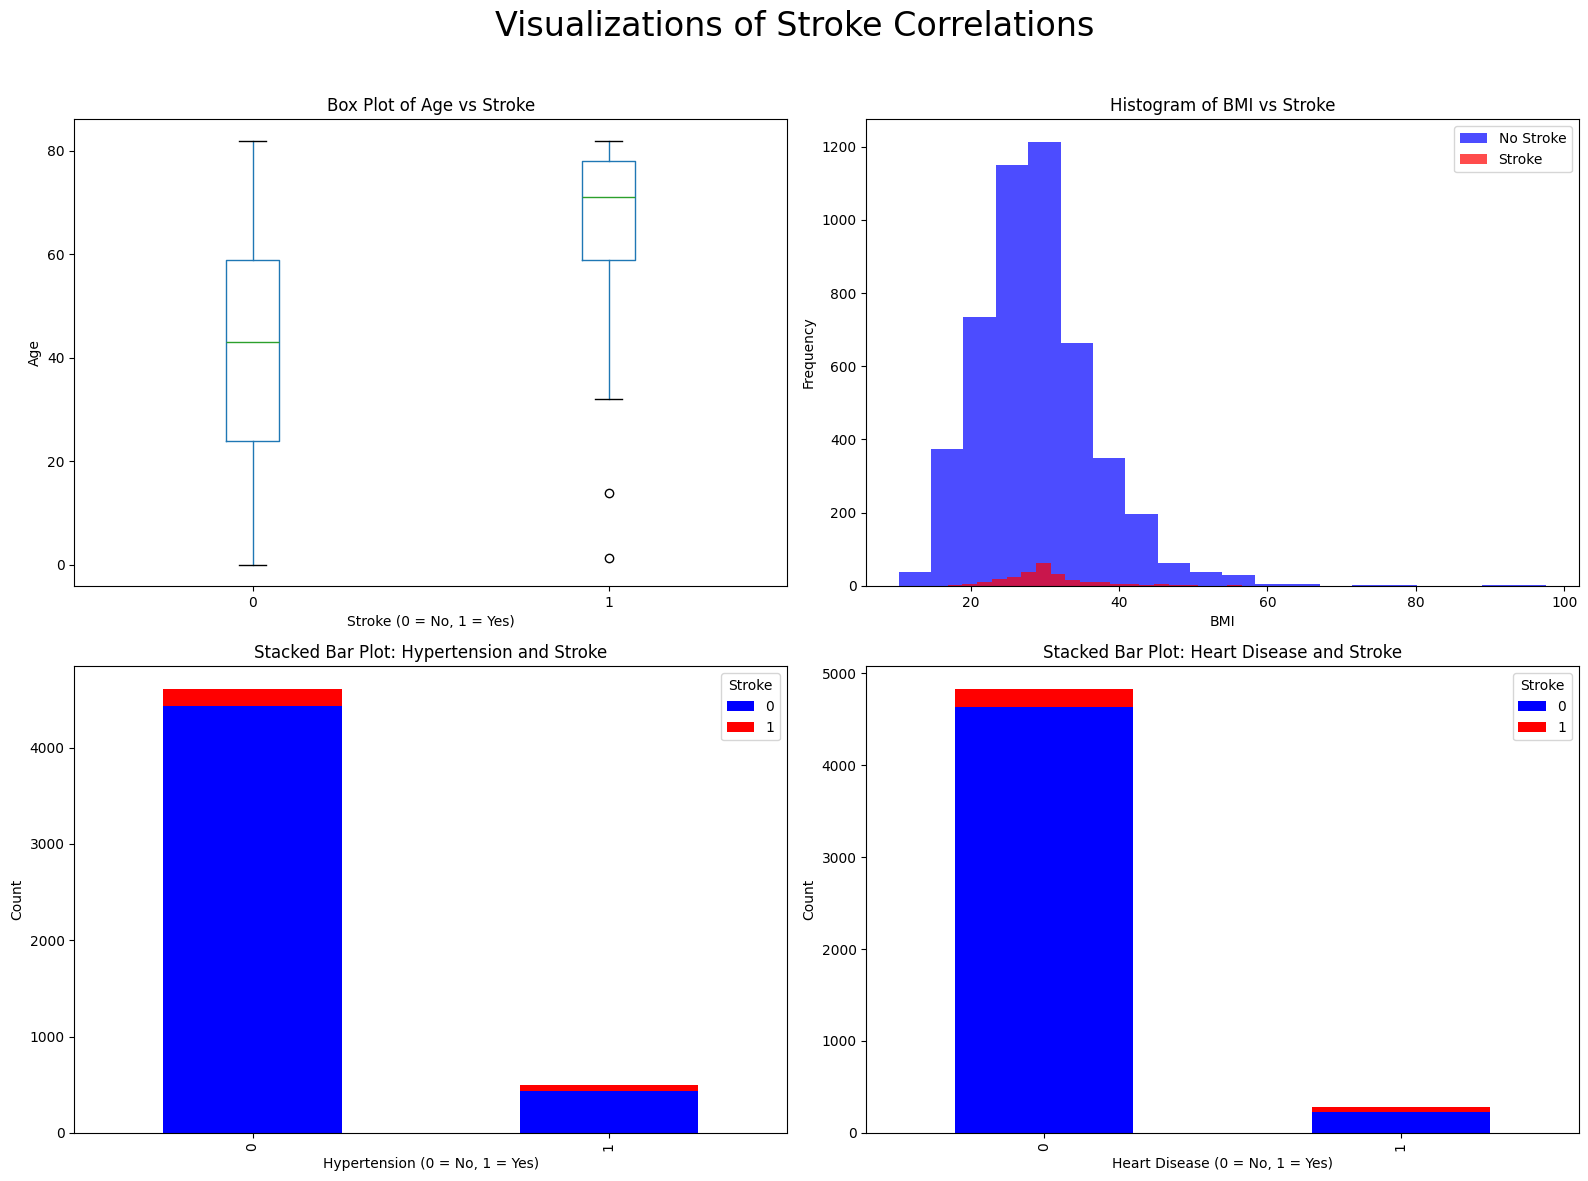

In [673]:
# Feature engineering by using visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Box plot of Age vs Stroke
df.boxplot(column='age', by='stroke', grid=False, ax=axs[0, 0])
axs[0, 0].set_title('Box Plot of Age vs Stroke')
axs[0, 0].set_xlabel('Stroke (0 = No, 1 = Yes)')
axs[0, 0].set_ylabel('Age')

# Histogram of BMI vs Stroke
axs[0, 1].hist(df[df['stroke'] == 0]['bmi'], bins=20, alpha=0.7, label='No Stroke', color='blue')
axs[0, 1].hist(df[df['stroke'] == 1]['bmi'], bins=20, alpha=0.7, label='Stroke', color='red')
axs[0, 1].set_title('Histogram of BMI vs Stroke')
axs[0, 1].set_xlabel('BMI')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Stacked Bar Plot: Hypertension and Stroke
hypertension_stroke = pd.crosstab(df['hypertension'], df['stroke'])
hypertension_stroke.plot(kind='bar', stacked=True, ax=axs[1, 0], color=['blue', 'red'])
axs[1, 0].set_title('Stacked Bar Plot: Hypertension and Stroke')
axs[1, 0].set_xlabel('Hypertension (0 = No, 1 = Yes)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend(title='Stroke')

# Stacked Bar Plot: Heart Disease and Stroke
heart_disease_stroke = pd.crosstab(df['heart_disease'], df['stroke'])
heart_disease_stroke.plot(kind='bar', stacked=True, ax=axs[1, 1], color=['blue', 'red'])
axs[1, 1].set_title('Stacked Bar Plot: Heart Disease and Stroke')
axs[1, 1].set_xlabel('Heart Disease (0 = No, 1 = Yes)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend(title='Stroke')

# Adjust layout and display the figure
plt.suptitle('Visualizations of Stroke Correlations', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [674]:
X  = df.drop(columns = ['id', 'ever_married', 'stroke'])
y = df['stroke']


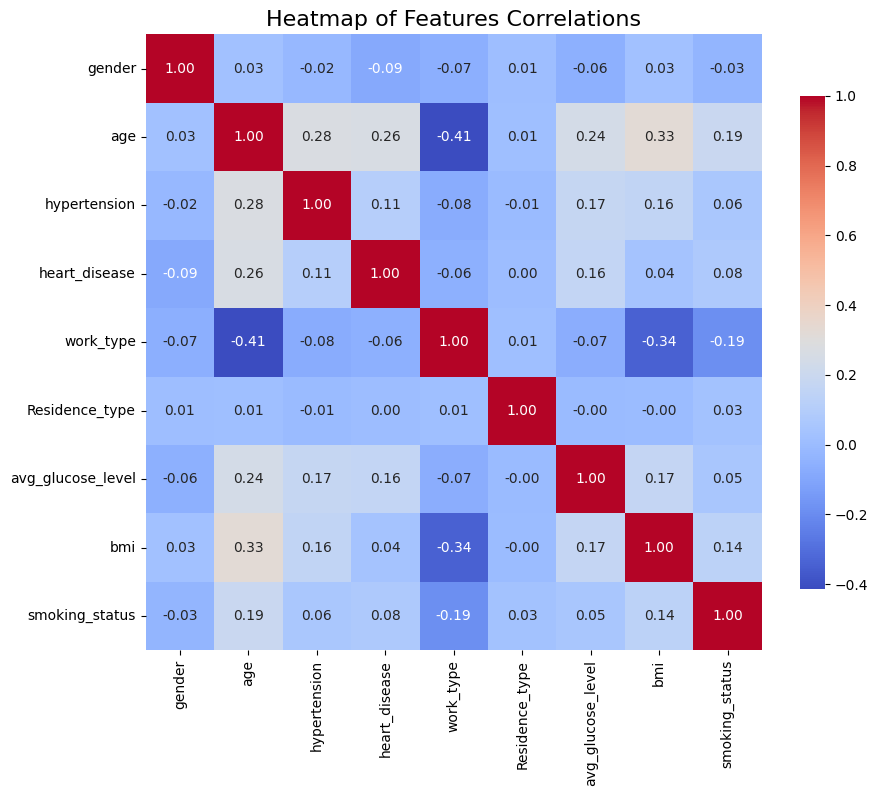

In [679]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap of Features Correlations', fontsize=16)
plt.show()

In [676]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
smote = SMOTE(random_state=42)
X_train_resh, y_train_resh = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resh)

#Replace hyperparameters to optain the best result
rf_model = RandomForestClassifier(max_features=2,n_estimators=100,max_depth=5,random_state=42)
logreg_model = LogisticRegression(C=0.1,penalty='l2',random_state=42)


rf_scores = cross_val_score(rf_model, X_train_scaled, y_train_resh, cv=10, scoring='recall')
logreg_scores = cross_val_score(logreg_model, X_train_scaled, y_train_resh, cv=10, scoring='recall')

print('Mean Recall Scores:')
print('Random Forest mean:', rf_scores.mean())
print('Logistic Regression mean:', logreg_scores.mean())



Mean Recall Scores:
Random Forest mean: 0.9072337211459466
Logistic Regression mean: 0.8294205337502982


In [677]:
rf_model.fit(X_train_scaled, y_train_resh)
logreg_model.fit(X_train_scaled, y_train_resh)

X_test_scaled = scaler.transform(X_test)

y_predict_rf = rf_model.predict(X_test_scaled)
y_predict_lr = logreg_model.predict(X_test_scaled)

print('Recall score:')
print(f'Random Forest: {recall_score(y_test, y_predict_rf, pos_label=1)}')
print(f'Logistic Regression: {recall_score(y_test, y_predict_lr, pos_label=1)}')

print('\nLog_loss:')
print(f'Random Forest: {log_loss(y_test, y_predict_rf)}')
print(f'Logistic Regression: {log_loss(y_test, y_predict_lr)}')

Recall score:
Random Forest: 0.6428571428571429
Logistic Regression: 0.6190476190476191

Log_loss:
Random Forest: 8.781672890303494
Logistic Regression: 9.204886041643423


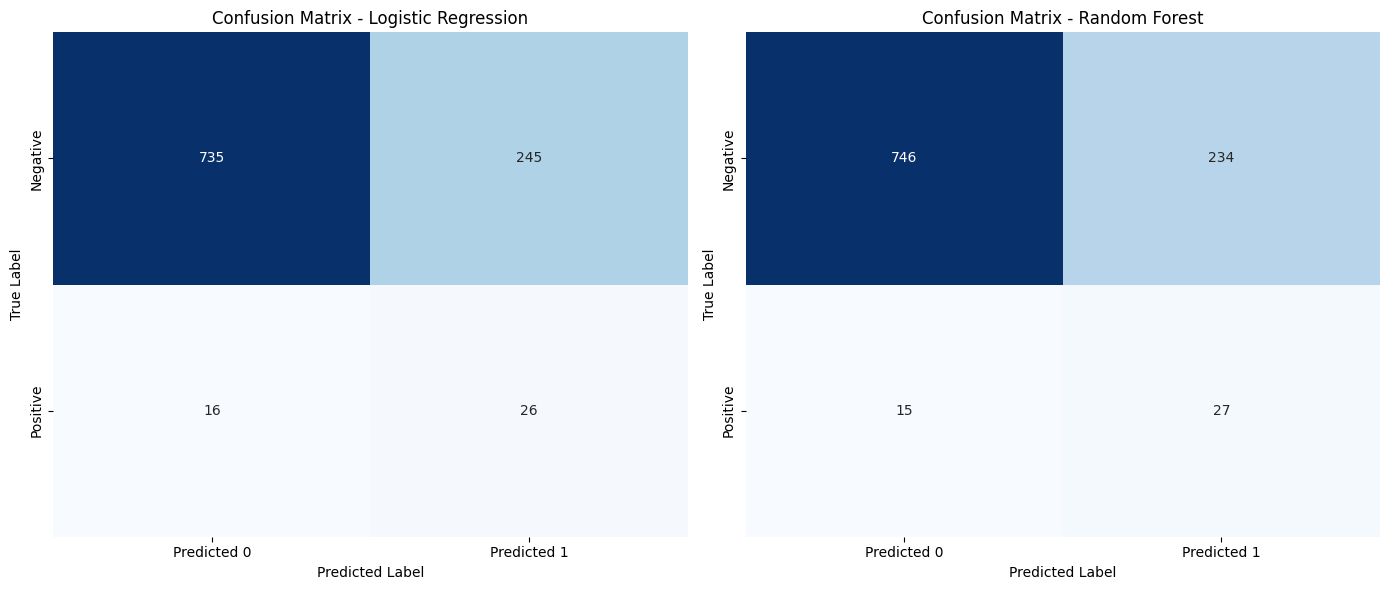

In [678]:
cm_log_reg = confusion_matrix(y_test, y_predict_lr)
cm_rf = confusion_matrix(y_test, y_predict_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Logistic Regression')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Negative', 'Positive'])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Random Forest')

plt.tight_layout()
plt.show()